In [1]:
import numpy as np
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram, EdgeHistogram, PyramidMatch
from grakel.kernels import SubgraphMatching, GraphletSampling, ShortestPath, RandomWalk, NeighborhoodHash
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Get Kernels

In [5]:
def get_VH(G):
    wl_kernel = VertexHistogram(normalize=True, sparse='auto')
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'VH')
    plt.show()
    return K

def get_PM(G, L_value, d_value):
    wl_kernel = PyramidMatch(normalize=True, L = L_value, d = d_value)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'PM')
    plt.show()
    return K

In [6]:
# K_dict['K_PM_4_6'] = get_PM(G_adj, 4, 6)

In [7]:
def get_NH(G, R_value = 3, bits_value = 8):
    wl_kernel = NeighborhoodHash(normalize=True, R = R_value, bits = bits_value)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'NH-{R_value}-{bits_value}')
    plt.show()
    return K

In [8]:
# K_dict['K_NH_1_6'] = get_NH(G_adj, 1, 6)

## WL [WeisfeilerLehman]

In [2]:
def get_WL(G, iter_num = 1):
    wl_kernel = WeisfeilerLehman(n_iter=iter_num, normalize=True, base_graph_kernel=VertexHistogram)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'WL-{iter_num}')
    plt.show()
    return K

## GS [GraphletSampling]

In [13]:
# def get_GS(G, k_num = 4):
#     wl_kernel = GraphletSampling(normalize=True, k=k_num)
#     K = wl_kernel.fit_transform(G)

#     plt.figure(figsize=(3, 2))
#     sns.heatmap(K)
#     plt.title(f'GS-{k_num}')
#     plt.show()

#     return K

In [14]:
# for k in range(5, 10):
#     name = f'K_GS_{k}'
#     K_dict[name] = get_GS(G_adj, k)

## SP [ShortestPath]

In [15]:
# def get_SP(G, algo):
#     wl_kernel = ShortestPath(normalize=True, algorithm_type=algo)
#     K = wl_kernel.fit_transform(G)

#     plt.figure(figsize=(3, 2))
#     sns.heatmap(K)
#     plt.title(f'SP {algo}')
#     plt.show()
    
#     return K

In [16]:
# name = 'K_SP'
# K_dict[name] = get_SP(G_adj, "dijkstra")

## RW [RandomWalk]

In [17]:
# def get_RW(G, lambda_value = 0.1):
#     wl_kernel = RandomWalk(lamda=lambda_value, normalize=True, kernel_type="exponential")
#     K = wl_kernel.fit_transform(G)

#     plt.figure(figsize=(3, 2))
#     sns.heatmap(K)
#     plt.title(f'RW-{lambda_value}')
#     plt.show()

#     return K

In [29]:
# for lam in range(5, 6, 5):
#     lam /= 10.
#     name = f'K_RW_{lam}'
#     K_dict[name] = get_RW(G_adj, lam)

In [3]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import SpectralClustering
from sklearn.svm import SVC
from sklearn import metrics

In [4]:
def cal_acc(y_true, y_pred):
    """
    Calculate clustering accuracy.
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind_row, ind_col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(ind_row, ind_col)]) * 1.0 / y_pred.size

def eva_clustering(K, y_true):
    '''
    Uses the Spectral Clustering to perform clustering
    '''
    y_pred = SpectralClustering(n_clusters = len(np.unique(y_true)), 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K)

    acc_score = cal_acc(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ari = metrics.cluster.adjusted_rand_score(y_true, y_pred)

    evaluation = {'accuary': acc_score, 'nmi': nmi, 'ari': ari}
    return evaluation


def eva_svc(K, y_true, K_test=None, y_test=None):
    '''
    Uses the SVM classifier to perform classification
    '''
    clf = SVC(kernel="precomputed", tol=1e-6, probability = True)
    clf.fit(K, y_true)

    y_pred_proba = clf.predict_proba(K)
    y_pred = clf.classes_[np.argmax(y_pred_proba, axis = 1)]
    acc_score = metrics.accuracy_score(y_true, y_pred)
    
    if K_test is None: 
        evaluation = {'accuracy': acc_score}
        return evaluation

    assert(y_test != None)
    y_test_pred_proba = clf.predict_proba(K_test)
    y_test_pred = clf.classes_[np.argmax(y_test_pred_proba, axis = 1)]
    acc_score_test = metrics.accuracy_score(y_test, y_test_pred)
    evaluation = {'train accuracy': acc_score, 'test accuracy': acc_score_test}
    return evaluation


In [24]:
dataname = 'AIDS'
print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname, verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

K_dict = dict()

for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)


for k, v in K_dict.items():
    print('========= {} ========'.format(k))
    # Evaluation 1: Spectral Clustering
    print('++++ Spectral Clustering ++++')
    results_clu = eva_clustering(v, y_adj)
    print(results_clu)

    # Evaluation 2: SVC
    print('+++++++ SVC +++++++')
    results_svc = eva_svc(v, y_adj)
    print(results_svc)

========= K_WL_1 ========
++++ Spectral Clustering ++++
{'accuary': 0.7905, 'nmi': 0.007692657631902082, 'ari': -0.013619729301634064}
+++++++ SVC +++++++
{'accuracy': 0.932}
========= K_WL_2 ========
++++ Spectral Clustering ++++
{'accuary': 0.7895, 'nmi': 0.008437243764974036, 'ari': -0.01497991674826363}
+++++++ SVC +++++++
{'accuracy': 0.973}
========= K_WL_3 ========
++++ Spectral Clustering ++++
{'accuary': 0.7895, 'nmi': 0.008437243764974036, 'ari': -0.01497991674826363}
+++++++ SVC +++++++
{'accuracy': 0.982}
========= K_WL_4 ========
++++ Spectral Clustering ++++
{'accuary': 0.7895, 'nmi': 0.008437243764974036, 'ari': -0.01497991674826363}
+++++++ SVC +++++++
{'accuracy': 0.986}
========= K_WL_5 ========
++++ Spectral Clustering ++++
{'accuary': 0.789, 'nmi': 0.008805880429479591, 'ari': -0.01565491263663497}
+++++++ SVC +++++++
{'accuracy': 0.99}


Fetching BZR dataset...
Finish fetching!


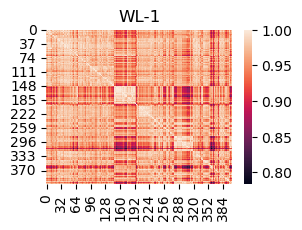

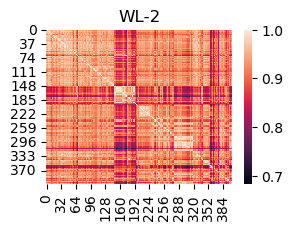

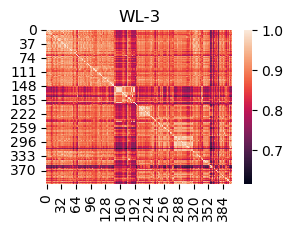

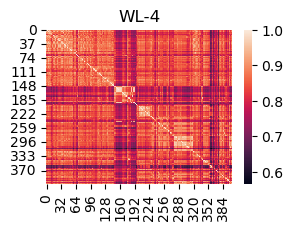

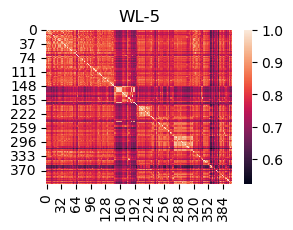

========= K_WL_1 ========
++++ Spectral Clustering ++++
{'accuary': 0.5555555555555556, 'nmi': 0.014169548230803759, 'ari': 0.023438452388989235}
+++++++ SVC +++++++
{'accuracy': 0.8419753086419753}
========= K_WL_2 ========
++++ Spectral Clustering ++++
{'accuary': 0.7209876543209877, 'nmi': 0.005704684976620521, 'ari': 0.034630890699181474}
+++++++ SVC +++++++
{'accuracy': 0.8691358024691358}
========= K_WL_3 ========
++++ Spectral Clustering ++++
{'accuary': 0.745679012345679, 'nmi': 0.0029405075294415646, 'ari': 0.02553094324900825}
+++++++ SVC +++++++
{'accuracy': 0.8938271604938272}
========= K_WL_4 ========
++++ Spectral Clustering ++++
{'accuary': 0.7580246913580246, 'nmi': 0.0018456973172628502, 'ari': 0.02029999188020122}
+++++++ SVC +++++++
{'accuracy': 0.9061728395061729}
========= K_WL_5 ========
++++ Spectral Clustering ++++
{'accuary': 0.7679012345679013, 'nmi': 0.003055683958624769, 'ari': 0.027669150469562583}
+++++++ SVC +++++++
{'accuracy': 0.9061728395061729}


In [25]:
dataname = 'BZR'
print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname, verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

K_dict = dict()

for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)


for k, v in K_dict.items():
    print('========= {} ========'.format(k))
    # Evaluation 1: Spectral Clustering
    print('++++ Spectral Clustering ++++')
    results_clu = eva_clustering(v, y_adj)
    print(results_clu)

    # Evaluation 2: SVC
    print('+++++++ SVC +++++++')
    results_svc = eva_svc(v, y_adj)
    print(results_svc)

Fetching COX2 dataset...
Finish fetching!


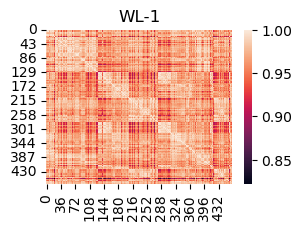

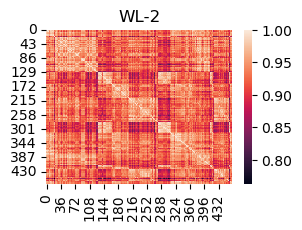

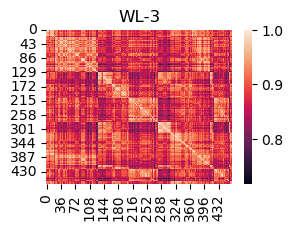

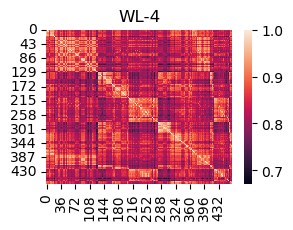

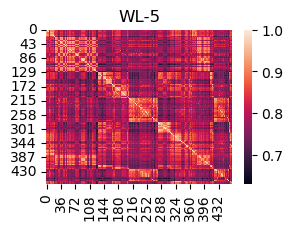

========= K_WL_1 ========
++++ Spectral Clustering ++++
{'accuary': 0.5460385438972163, 'nmi': 8.256179616961946e-06, 'ari': -0.0017233609109501247}
+++++++ SVC +++++++
{'accuracy': 0.8351177730192719}
========= K_WL_2 ========
++++ Spectral Clustering ++++
{'accuary': 0.582441113490364, 'nmi': 0.00023274567840398153, 'ari': -0.0038088489256711826}
+++++++ SVC +++++++
{'accuracy': 0.8586723768736617}
========= K_WL_3 ========
++++ Spectral Clustering ++++
{'accuary': 0.5289079229122056, 'nmi': 7.971209527714155e-05, 'ari': -0.0008674841137179457}
+++++++ SVC +++++++
{'accuracy': 0.867237687366167}
========= K_WL_4 ========
++++ Spectral Clustering ++++
{'accuary': 0.6359743040685225, 'nmi': 0.0003417328800725292, 'ari': 0.0039007289834214016}
+++++++ SVC +++++++
{'accuracy': 0.8886509635974305}
========= K_WL_5 ========
++++ Spectral Clustering ++++
{'accuary': 0.5974304068522484, 'nmi': 0.0003977612821967033, 'ari': -0.005042102340266076}
+++++++ SVC +++++++
{'accuracy': 0.89079229122

In [26]:
dataname = 'COX2'
print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname, verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

K_dict = dict()

for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)


for k, v in K_dict.items():
    print('========= {} ========'.format(k))
    # Evaluation 1: Spectral Clustering
    print('++++ Spectral Clustering ++++')
    results_clu = eva_clustering(v, y_adj)
    print(results_clu)

    # Evaluation 2: SVC
    print('+++++++ SVC +++++++')
    results_svc = eva_svc(v, y_adj)
    print(results_svc)

Fetching DHFR dataset...
Finish fetching!


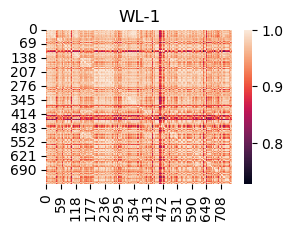

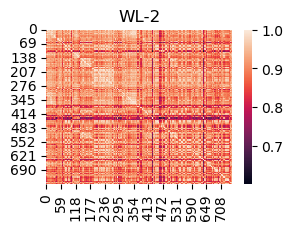

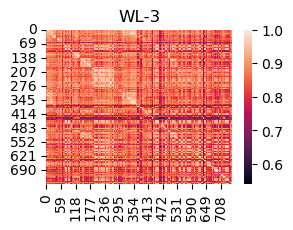

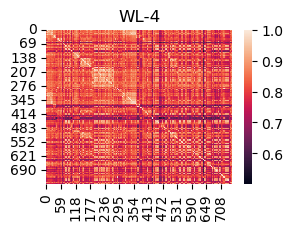

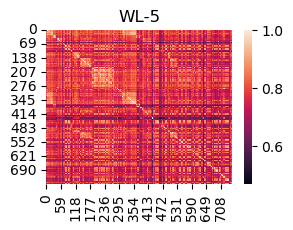

========= K_WL_1 ========
++++ Spectral Clustering ++++
{'accuary': 0.5912698412698413, 'nmi': 0.00703993015318419, 'ari': -2.5761106627553195e-05}
+++++++ SVC +++++++
{'accuracy': 0.708994708994709}
========= K_WL_2 ========
++++ Spectral Clustering ++++
{'accuary': 0.5052910052910053, 'nmi': 1.9050749265754674e-05, 'ari': -0.00126049855676813}
+++++++ SVC +++++++
{'accuracy': 0.7592592592592593}
========= K_WL_3 ========
++++ Spectral Clustering ++++
{'accuary': 0.6243386243386243, 'nmi': 0.0003444156268977099, 'ari': -0.002993942828489007}
+++++++ SVC +++++++
{'accuracy': 0.794973544973545}
========= K_WL_4 ========
++++ Spectral Clustering ++++
{'accuary': 0.656084656084656, 'nmi': 0.000149872715080093, 'ari': -0.0027659500065011}
+++++++ SVC +++++++
{'accuracy': 0.828042328042328}
========= K_WL_5 ========
++++ Spectral Clustering ++++
{'accuary': 0.6640211640211641, 'nmi': 0.0002449450935516054, 'ari': -0.0032474532267627544}
+++++++ SVC +++++++
{'accuracy': 0.8373015873015873}


In [31]:
dataname = 'DHFR'
print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname, verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

K_dict = dict()

for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)


for k, v in K_dict.items():
    print('========= {} ========'.format(k))
    # Evaluation 1: Spectral Clustering
    print('++++ Spectral Clustering ++++')
    results_clu = eva_clustering(v, y_adj)
    print(results_clu)

    # Evaluation 2: SVC
    print('+++++++ SVC +++++++')
    results_svc = eva_svc(v, y_adj)
    print(results_svc)

Fetching Synthie dataset...
Finish fetching!


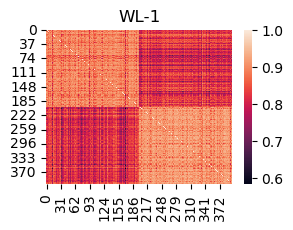

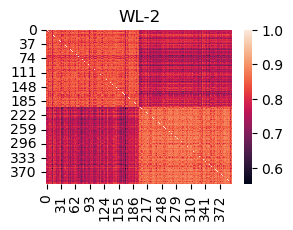

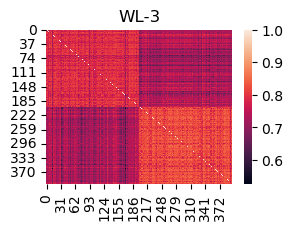

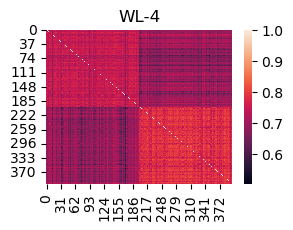

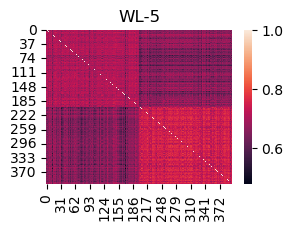

========= K_WL_1 ========
++++ Spectral Clustering ++++
{'accuary': 0.51, 'nmi': 0.426517061750611, 'ari': 0.29759749195229834}
+++++++ SVC +++++++
{'accuracy': 0.3175}
========= K_WL_2 ========
++++ Spectral Clustering ++++
{'accuary': 0.5075, 'nmi': 0.4286349320986716, 'ari': 0.29836125189552953}
+++++++ SVC +++++++
{'accuracy': 0.2775}
========= K_WL_3 ========
++++ Spectral Clustering ++++
{'accuary': 0.5, 'nmi': 0.42741961210005835, 'ari': 0.29622178401388016}
+++++++ SVC +++++++
{'accuracy': 0.3525}
========= K_WL_4 ========
++++ Spectral Clustering ++++
{'accuary': 0.4975, 'nmi': 0.4272598874990857, 'ari': 0.2959755343246023}
+++++++ SVC +++++++
{'accuracy': 0.09}
========= K_WL_5 ========
++++ Spectral Clustering ++++
{'accuary': 0.5025, 'nmi': 0.42194257402969787, 'ari': 0.2953471166901927}
+++++++ SVC +++++++
{'accuracy': 0.275}


In [39]:
dataname = 'Synthie'
print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname, verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

K_dict = dict()

for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)


for k, v in K_dict.items():
    print('========= {} ========'.format(k))
    # Evaluation 1: Spectral Clustering
    print('++++ Spectral Clustering ++++')
    results_clu = eva_clustering(v, y_adj)
    print(results_clu)

    # Evaluation 2: SVC
    print('+++++++ SVC +++++++')
    results_svc = eva_svc(v, y_adj)
    print(results_svc)

Fetching ENZYMES dataset...
Finish fetching!


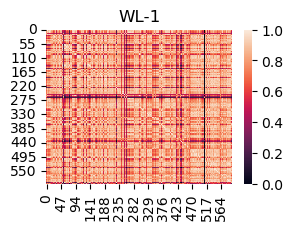

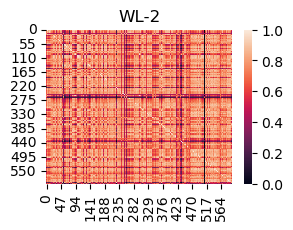

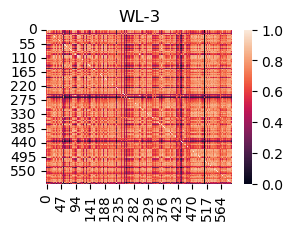

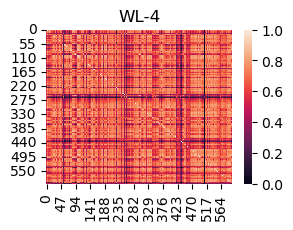

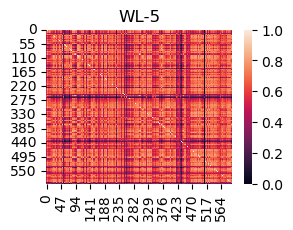

========= K_WL_1 ========
++++ Spectral Clustering ++++
{'accuary': 0.265, 'nmi': 0.06494752912850212, 'ari': 0.03198729134163753}
+++++++ SVC +++++++
{'accuracy': 0.37}
========= K_WL_2 ========
++++ Spectral Clustering ++++
{'accuary': 0.24833333333333332, 'nmi': 0.05004577589200472, 'ari': 0.02066220827611241}
+++++++ SVC +++++++
{'accuracy': 0.46}
========= K_WL_3 ========
++++ Spectral Clustering ++++
{'accuary': 0.255, 'nmi': 0.061008857689759104, 'ari': 0.02424039722838933}
+++++++ SVC +++++++
{'accuracy': 0.5033333333333333}
========= K_WL_4 ========
++++ Spectral Clustering ++++
{'accuary': 0.25666666666666665, 'nmi': 0.06001082121720392, 'ari': 0.023793213154138425}
+++++++ SVC +++++++
{'accuracy': 0.555}
========= K_WL_5 ========
++++ Spectral Clustering ++++
{'accuary': 0.255, 'nmi': 0.06200313542988057, 'ari': 0.02443981279806918}
+++++++ SVC +++++++
{'accuracy': 0.5683333333333334}


In [40]:
dataname = 'ENZYMES'
print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname, verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

K_dict = dict()

for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)


for k, v in K_dict.items():
    print('========= {} ========'.format(k))
    # Evaluation 1: Spectral Clustering
    print('++++ Spectral Clustering ++++')
    results_clu = eva_clustering(v, y_adj)
    print(results_clu)

    # Evaluation 2: SVC
    print('+++++++ SVC +++++++')
    results_svc = eva_svc(v, y_adj)
    print(results_svc)

Fetching PROTEINS_full dataset...
Finish fetching!


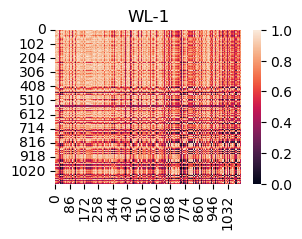

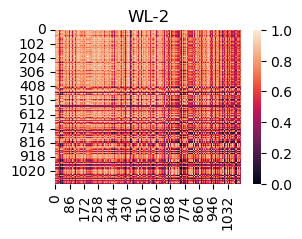

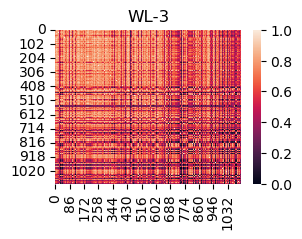

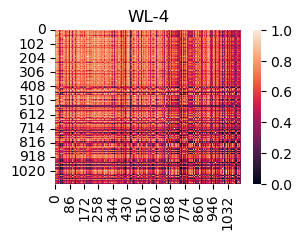

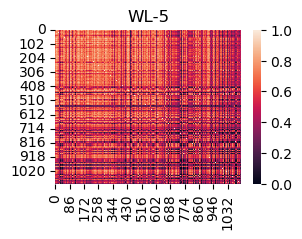

========= K_WL_1 ========
++++ Spectral Clustering ++++
{'accuary': 0.5822102425876011, 'nmi': 0.02102910798241362, 'ari': 0.02618816195284175}
+++++++ SVC +++++++
{'accuracy': 0.7439353099730458}
========= K_WL_2 ========
++++ Spectral Clustering ++++
{'accuary': 0.5741239892183289, 'nmi': 0.018195049421050446, 'ari': 0.021094778836398462}
+++++++ SVC +++++++
{'accuracy': 0.7816711590296496}
========= K_WL_3 ========
++++ Spectral Clustering ++++
{'accuary': 0.573225516621743, 'nmi': 0.017856259759180648, 'ari': 0.02056066805821594}
+++++++ SVC +++++++
{'accuracy': 0.8032345013477089}
========= K_WL_4 ========
++++ Spectral Clustering ++++
{'accuary': 0.573225516621743, 'nmi': 0.017856259759180648, 'ari': 0.02056066805821594}
+++++++ SVC +++++++
{'accuracy': 0.8149146451033243}
========= K_WL_5 ========
++++ Spectral Clustering ++++
{'accuary': 0.573225516621743, 'nmi': 0.017856259759180648, 'ari': 0.02056066805821594}
+++++++ SVC +++++++
{'accuracy': 0.8301886792452831}


In [51]:
dataname = 'PROTEINS_full'
print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname, verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

K_dict = dict()

for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)


for k, v in K_dict.items():
    print('========= {} ========'.format(k))
    # Evaluation 1: Spectral Clustering
    print('++++ Spectral Clustering ++++')
    results_clu = eva_clustering(v, y_adj)
    print(results_clu)

    # Evaluation 2: SVC
    print('+++++++ SVC +++++++')
    results_svc = eva_svc(v, y_adj)
    print(results_svc)

Fetching COIL-RAG dataset...
Finish fetching!
<class 'numpy.ndarray'>


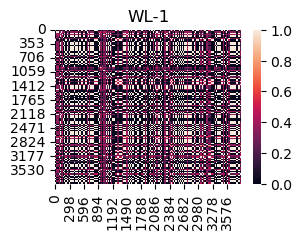

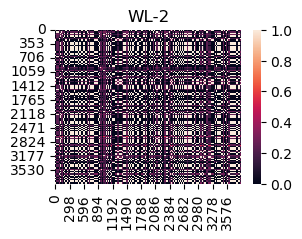

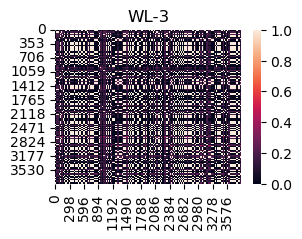

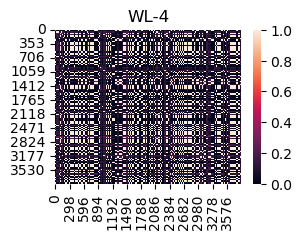

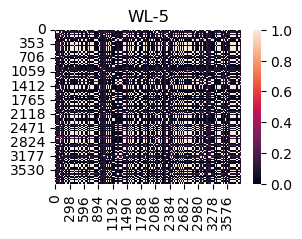

========= K_WL_1 ========
++++ Spectral Clustering ++++


KeyboardInterrupt: 

In [70]:
dataname = 'COIL-RAG'
print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname, verbose=False, prefer_attr_nodes=False, produce_labels_nodes=True)
print(f'Finish fetching!')
G, y = data.data, data.target
G_new = []
y_new = []
for i, one in enumerate(G):
    if len(one[0]) != 0:
        G_new.append(one)
        y_new.append(y[i])
y_new = np.array(y_new)

G_adj = np.row_stack([np.array(G_new)[np.where(y_new == num)[0].astype(np.uint64)] for num in np.unique(y_new)])
y_adj = np.concatenate([y_new[np.argwhere(y_new == num).ravel()] for num in np.unique(y_new)])

K_dict = dict()

for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)


for k, v in K_dict.items():
    print('========= {} ========'.format(k))
    # Evaluation 1: Spectral Clustering
    print('++++ Spectral Clustering ++++')
    results_clu = eva_clustering(v, y_adj)
    print(results_clu)

    # Evaluation 2: SVC
    print('+++++++ SVC +++++++')
    results_svc = eva_svc(v, y_adj)
    print(results_svc)

In [68]:
for one in G_new:
    if len(one[0]) == 0:
        print(one)

Fetching Cuneiform dataset...
Finish fetching!


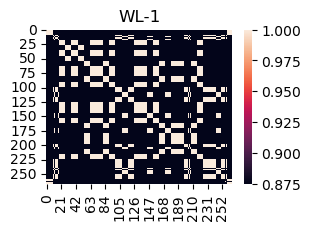

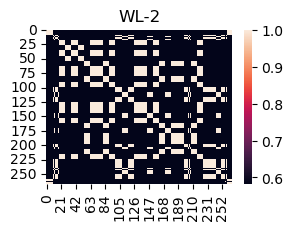

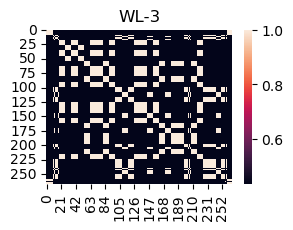

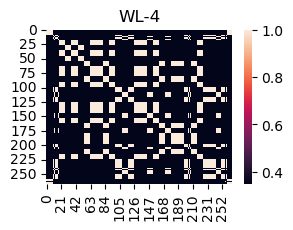

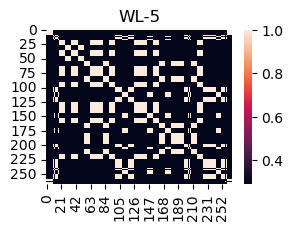

========= K_WL_1 ========
++++ Spectral Clustering ++++
{'accuary': 0.2247191011235955, 'nmi': 0.5878194114290884, 'ari': 0.17274502526071192}
+++++++ SVC +++++++
{'accuracy': 0.18726591760299627}
========= K_WL_2 ========
++++ Spectral Clustering ++++
{'accuary': 0.2397003745318352, 'nmi': 0.6278725551183876, 'ari': 0.2180557482219324}
+++++++ SVC +++++++
{'accuracy': 0.18726591760299627}
========= K_WL_3 ========
++++ Spectral Clustering ++++
{'accuary': 0.250936329588015, 'nmi': 0.6224759120286611, 'ari': 0.21394579477365752}
+++++++ SVC +++++++
{'accuracy': 0.18726591760299627}
========= K_WL_4 ========
++++ Spectral Clustering ++++
{'accuary': 0.250936329588015, 'nmi': 0.6368879745935084, 'ari': 0.22269518661309795}
+++++++ SVC +++++++
{'accuracy': 0.18726591760299627}
========= K_WL_5 ========
++++ Spectral Clustering ++++
{'accuary': 0.24719101123595505, 'nmi': 0.6357430165842434, 'ari': 0.22082308148216928}
+++++++ SVC +++++++
{'accuracy': 0.18726591760299627}


In [5]:
dataname = 'Cuneiform'
print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname, verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

K_dict = dict()

for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)


for k, v in K_dict.items():
    print('========= {} ========'.format(k))
    # Evaluation 1: Spectral Clustering
    print('++++ Spectral Clustering ++++')
    results_clu = eva_clustering(v, y_adj)
    print(results_clu)

    # Evaluation 2: SVC
    print('+++++++ SVC +++++++')
    results_svc = eva_svc(v, y_adj)
    print(results_svc)

In [73]:
for one in G_adj:
    for (i, j) in one[0]:
        if (i == 0) & (j == 0):
            print('find')

In [74]:
G_adj

array([[{(30, 29), (29, 30)}, {30: 1, 29: 1}, {}],
       [{(47, 46), (45, 46), (46, 45), (47, 45), (45, 47), (46, 47)},
        {47: 2, 45: 2, 46: 2}, {}],
       [{(293, 292), (292, 293)}, {293: 1, 292: 1}, {}],
       ...,
       [{(11061, 11062), (11062, 11061)}, {11061: 1, 11062: 1}, {}],
       [{(11425, 11424), (11423, 11424), (11424, 11423), (11424, 11425)},
        {11425: 1, 11423: 1, 11424: 2}, {}],
       [{(11736, 11737), (11737, 11736)}, {11736: 1, 11737: 1}, {}]],
      dtype=object)

In [75]:
int('0, 0')

ValueError: invalid literal for int() with base 10: '0, 0'

In [76]:
y

array([62, 64, 45, ...,  2,  7, 50])